In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
from PIL import ImageFont, ImageDraw, Image 
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime as dt
import tensorflow as tf
import string
import tensorflow.compat.v1 as v1
v1.disable_eager_execution()
bold = '\033[1m'
end = '\033[0m'

In [ ]:
def variable(name,shape,initializer,weight_decay = None):
  '''
  create parameter tensor
  '''
  var = v1.get_variable(name, shape, initializer = initializer)
  if weight_decay is not None:
    weight_loss = tf.multiply(tf.nn.l2_loss(var),weight_decay, name="weight_loss")
    tf.add_to_collection('losses', weight_loss)
  return var

#need to customize activation and lrn
def conv_block(block_num,
               input_data,
               weights, 
               weight_initializer=tf.random_normal_initializer(),
               bias_initializer=tf.constant_initializer(0.0),
               conv_op=[1,1,1,1],
               conv_padding='SAME',
               weight_decay=None,
               lrn=True,
               dropout=0.9, 
               activation=True):
  '''
  convolutional block
  '''
  with v1.variable_scope('conv'+ str(block_num), reuse = v1.AUTO_REUSE) as scope:
    input_data = tf.nn.dropout(input_data, dropout)
    kernel = variable('weights', weights, initializer = weight_initializer, weight_decay = weight_decay)
    biases = variable('biases', weights[3], initializer=bias_initializer, weight_decay=None)
    conv = tf.nn.conv2d(input_data, kernel, conv_op, padding=conv_padding)
    pre_activation = tf.nn.bias_add(conv, biases)
    if lrn==True:
      pre_activation = tf.nn.lrn(pre_activation, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75,name='norm')
    if activation:
      conv_out = tf.nn.relu(pre_activation, name=scope.name)
      return conv_out
    else:
      return pre_activation

def dense_block(block_num,
                input_data,
                neurons,
                weight_initializer=tf.random_normal_initializer(),
                bias_initializer=tf.constant_initializer(0.0),
                weight_decay=None,
                activation=True, 
                dropout=0.9):
  '''
  Fully connected block
  '''
  with tf.variable_scope('dense'+ str(block_num), reuse = tf.AUTO_REUSE) as scope:
    input_data = tf.nn.dropout(input_data, dropout)
    weights = variable('weights', [input_data.shape[1], neurons], \
                       initializer=weight_initializer, weight_decay = weight_decay)
    biases = variable('biases', [1,neurons], initializer = bias_initializer, weight_decay = None)
    dense = tf.matmul(input_data,weights)+biases
    if activation:
      dense=tf.nn.relu(dense, name=scope.name)
    return dense

def decoding(encoded_data, type = 'logit'):
  prediction = np.argmax(encoded_data, 1)
  decoded_prediction = ''
  for dp in prediction:
    predicted_text = all_chr[dp]
    decoded_prediction += predicted_text
  return decoded_prediction

In [ ]:
def inference(image_batch, class_count, weights,
              dropout=[0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9],
              wd=None):
  '''
  Forward propagation
  '''

  i = 0
           
  conv_op=[[1,1,1,1],[1,1,1,1],[1,1,1,1], [1,1,1,1]]
  
  conv1 = conv_block(1,image_batch,weights[i], conv_op = conv_op[i], conv_padding='SAME', dropout=dropout[i],weight_decay=wd)
  i=i+1
  pool1=tf.nn.max_pool(conv1, ksize=[1, 4, 4, 1], strides=[1,4,4,1],padding='SAME', name='pool1') #32x32
  
  conv2 = conv_block(2,pool1,weights[i], conv_op = conv_op[i], conv_padding='SAME', dropout=dropout[i],weight_decay=wd)
  i=i+1
  pool2=tf.nn.max_pool(conv2, ksize=[1, 4, 4, 1], strides=[1,4,4,1],padding='SAME', name='pool2') #8x8
  
  conv3 = conv_block(3,pool2,weights[i], conv_op = conv_op[i], conv_padding='SAME', dropout=dropout[i],weight_decay=wd)
  i=i+1
  pool3=tf.nn.max_pool(conv3, ksize=[1, 4, 4, 1], strides=[1,4,4,1],padding='SAME', name='pool3') #2x2
  
  conv4 = conv_block(4,pool3,weights[i], conv_op = conv_op[i], conv_padding='SAME', dropout=dropout[i],weight_decay=wd)
  i=i+1
  pool4=tf.nn.max_pool(conv4, ksize=[1, 2, 2, 1], strides=[1,2,2,1],padding='SAME', name='pool4')#1x1

  flat=tf.reshape(pool4, [tf.shape(image_batch)[0], class_count], name='flat')
		
  return flat

In [ ]:
def img_list(image_folder, image_name_list):
  list = []
  for il in image_name_list:
    image = cv2.imread(image_folder + il)
    plt.imshow(image)
    plt.show()
    list.append(image)
  return list
    
def show(inp, string =""):
    print(string)
    if inp.shape !=3:
      plt.imshow(inp, cmap = 'gray')
    else:
      plt.imshow(inp)
    plt.show() 
    print ()
    
def multi_show(inp, string="", fig_size = (18,18), row = 10, col = 20):
  print(string)
  fig=plt.figure(figsize=fig_size)
  for i, r in enumerate(inp):
    fig.add_subplot(row,col, i+1)
    if r.shape !=3:
      plt.imshow(r, cmap = 'gray')
    else:
      plt.imshow(r)
  plt.show()
  print(len(inp))
  print()
  
def find_roi(inp_list, resize = None, thres = 127, 
             d_kernel_size = (3, 3), e_kernel_size = (1,1), 
             w_min = 100, w_max = 2000, h_min = 20, h_max = 1000,
             area_thres = 0.3, roi_resize = None, extra_pixel = 3, 
             show_bool = True, dis_size=8, dis_row=10, dis_col=10, arrange = 0):
  all_inp = []
  for inp in inp_list:
    all_roi = []
    if len(inp.shape) == 3:
      #convert it to gray scale
      inp = cv2.cvtColor(inp,cv2.COLOR_BGR2GRAY) 
      
    #resize image if needed
    if resize !=0: 
      inp = cv2.resize(inp, (inp.shape[1]*resize,inp.shape[0]*resize))
     
    #perform thresholding
    if thres != None:
      _, inp = cv2.threshold(inp,thres,255,cv2.THRESH_BINARY_INV) 
    
    #keep thresholded image in seperately
    inp_org = inp
    
    #kernel for erosion
    e_kernel = np.ones(e_kernel_size, np.uint8)
    #erode image
    inp = cv2.erode(inp, e_kernel, iterations=1)
    #kernel for dilation
    d_kernel = np.ones(d_kernel_size, np.uint8)
    #dilate image
    inp = cv2.dilate(inp, d_kernel, iterations=1) 
 
    if show_bool == True:
      show(inp, "dilated image")
    
    #find contours
    ctrs,_ = cv2.findContours(inp.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) 
    #sort contours
    sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[arrange]) 
    
    #dicard useless rois
    for i, ctr in enumerate(sorted_ctrs):
      discard = 0
      #get bounding box
      x, y, w, h = cv2.boundingRect(ctr) 
      if w_min<w<w_max and h_min<h<h_max:
        
        for j, temp_ctrs in enumerate(sorted_ctrs):
              temp_x, temp_y, temp_w, temp_h = cv2.boundingRect(temp_ctrs)
            
              if j != i and temp_w <w_max and temp_h <h_max:
                
                #if there is overlap and intersection area is more than threshold then discard the bounding box
                 if (temp_x<x<temp_x+temp_w and temp_y<y<temp_y+temp_h) or (temp_x<x+w<temp_x+temp_w and temp_y<y+h<temp_y+temp_h):
                  dx = min((temp_x + temp_w),(x+w)) - max(temp_x, x)
                  dy = min((temp_y + temp_h),(y+h)) - max(temp_y, y)
                  if(dx*dy>0):
                    intersection_area = dx * dy
                  else:
                    intersection_area = 0
                  if (intersection_area/(w*h) > area_thres):
                    discard += 1
                    break
                    
        #if not discarded then add bounding box in list
        if discard == 0: 
          roi = inp_org[y:y+h-extra_pixel, x:x+w] 
          if roi_resize !=None:
            roi = cv2.resize(roi, roi_resize)
          all_roi.append(roi)
    
    if show_bool == True:
      multi_show(all_roi, "all ROIs",fig_size=(dis_size, dis_size), row=dis_row, col=dis_col)
    all_inp.append(all_roi)
#     print(len(all_roi))
  return all_inp

In [ ]:
digit = '0 1 2 3 4 5 6 7 8 9 ' #all digits
lc = 'a b c d e f g h i j k l m n o p q r s t u v w x y z ' #all lower case
all_uc = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ' #all upper case
sel_uc = 'A B D E F G H J K L M N Q R T Y ' #selected upper case
all_sign = '''! @ # $ % ^ & ? / ( ) { } [ ] < > * - + = \ : ; ' . ''' #all useful signs
sel_sign = '''. ( ) % ''' #selected signs


digi_perc = digit + '% ' #digits with percentage

digi_lc = digit + lc #digits and all lower case
digi_uc = digit + all_uc #digits and all upper case
all_letters = lc + all_uc #all letters
digi_all_letters = digi_lc + all_letters #all digits and all letters
digi_all_letters_all_sign = digi_all_letters + all_sign #all digits, all letters and all useful signs

lc_sel_uc = lc + sel_uc
digi_lc_sel_uc = digit + lc + sel_uc
digi_all_letters_sel_sign = digi_all_letters + sel_sign # all digit, all letters and selected signs
digi_lc_sel_uc_sel_sign = digi_lc + sel_uc + sel_sign # all digits, all lower case, selected upper case and selected signs
digi_lc_sel_uc_all_sign = digi_lc + sel_uc + all_sign # all digits, all lower case, selected upper case and all signs

In [ ]:
path = "/content/drive/MyDrive/SD_AI Project_2/Resources/"

# digi, lc, sel uc
checkpoint_restore = path + "checkpoints/checkpoint_digi_lc_sel_uc_sel_sign_1.ckpt"
all_chr = digi_lc_sel_uc_sel_sign.replace(" ", "")
class_count = 56
weights=[[3,3,1,16],
         [3,3,16,24],
         [3,3,24,42], 
         [3,3,42,56]]

test_file_path = path +"test_images/"
test_file_list = os.listdir(test_file_path)

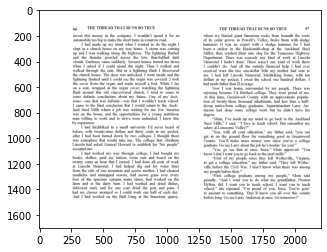

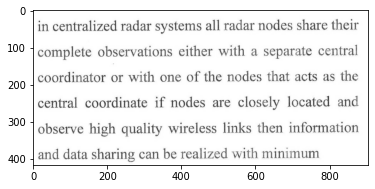

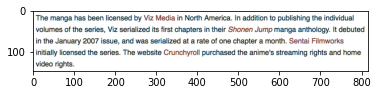

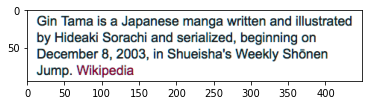

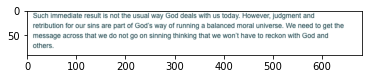

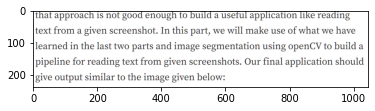

total number of images: 6 

total number of sentences in image 1 : 602 

total number of sentences in image 2 : 35 

total number of sentences in image 3 : 5 

total number of sentences in image 4 : 4 

total number of sentences in image 5 : 4 

total number of sentences in image 6 : 5 

total number of words in sentence 1 of image 1 : 7 

total number of words in sentence 2 of image 1 : 1 

total number of words in sentence 3 of image 1 : 7 

total number of words in sentence 4 of image 1 : 1 

total number of words in sentence 5 of image 1 : 1 

total number of words in sentence 6 of image 1 : 2 

total number of words in sentence 7 of image 1 : 1 

total number of words in sentence 8 of image 1 : 1 

total number of words in sentence 9 of image 1 : 1 

total number of words in sentence 10 of image 1 : 1 

total number of words in sentence 11 of image 1 : 2 

total number of words in sentence 12 of image 1 : 1 

total number of words in sentence 13 of image 1 : 1 

total number of wo

In [ ]:
image_list = img_list(test_file_path, test_file_list)
    
# get the list of list for sentences of image in image list
sentences = find_roi(inp_list = image_list, resize = 10, thres = 157,
                 d_kernel_size = (25,150), e_kernel_size = (1,1),
                 w_min = 100, w_max = 20000, h_min = 20, h_max = 10000,
                 roi_resize = None, extra_pixel = 0, 
                 show_bool = False, dis_size = 18, dis_row = 5, dis_col = 2, arrange = 1)
print("total number of images:", len(sentences),'\n') #[[]]

all_words = []
for i in range(len(image_list)):
    print("total number of sentences in image",i+1, ':', len(sentences[i]),'\n')
    words = find_roi(inp_list = sentences[i], resize = 1, thres = None,
                   d_kernel_size = (15,45), e_kernel_size = (1,1),
                   w_min = 50, w_max = 2000, h_min = 10, h_max = 1000,
                   roi_resize = None, extra_pixel = 0, 
                   show_bool = False, dis_size = 18, dis_row = 10, dis_col = 10)
    all_words.append(words) #[[[]]]

all_characters = []    
for i in range(len(image_list)):
    characters_in_image = []
    for j in range(len(all_words[i])):
        print("total number of words in sentence",j+1,'of image', i+1, ':', len(all_words[i][j]),'\n')
        characters = find_roi(inp_list = all_words[i][j], resize = 1, thres = None,
                       d_kernel_size = (20,1), e_kernel_size = (1,1),
                       w_min = 10, w_max = 500, h_min = 30, h_max = 500,
                       roi_resize = (128,128), extra_pixel = 10, 
                       show_bool = False, dis_size = 18, dis_row = 20, dis_col = 20)
        characters_in_image.append(characters)   
    all_characters.append(characters_in_image)

In [ ]:
for im in all_characters:
  for k,s in enumerate(im):
    for j,w in enumerate(s):
      for i,ar in enumerate(w):
        w[i] = np.reshape(ar, (128,128,1))
      s[j] = np.float32(np.array(w))
    im[k] = np.array(s)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [ ]:
X=v1.placeholder("float32",[None,128,128,1])
decoded_text = []
logit = inference(X, class_count, weights)
init=v1.global_variables_initializer()
saver=v1.train.Saver()

with v1.Session() as sess:
  sess.run(v1.global_variables_initializer())
  sess.run(v1.local_variables_initializer())
  saver.restore(sess,checkpoint_restore)
  ax = plt.gca()
  fig = plt.gcf()
  for i,im in enumerate(all_characters):
      print("=================================")
      print(bold + "~~~~~given image", i+1, '~~~~~~')
      ax = plt.gca()
      fig = plt.gcf()
      fig.set_size_inches(12, 7)
      plt.axis('off')
      ax.grid(False)
      plt.imshow(image_list[i])
      plt.show()  
      print(bold + "~~~~~predicted text~~~~~\n", end = '')
      for s in im:
        for w in s:
          text = logit.eval({X:w})
          decoded_text = decoding(text, type = 'logit')
          print(str(decoded_text), end = ' ')
        print()
      print("\n=================================\n\n\n")